In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/AVP")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("/content/gdrive/My Drive/AVP")

In [4]:
!pip install allennlp

     |████████████████████████████████| 5.7MB 3.3MB/s 
     |████████████████████████████████| 256kB 47.2MB/s 
     |████████████████████████████████| 51kB 21.7MB/s 
     |████████████████████████████████| 1.8MB 41.6MB/s 
     |████████████████████████████████| 225kB 50.7MB/s 
     |████████████████████████████████| 245kB 52.8MB/s 
     |████████████████████████████████| 51kB 24.5MB/s 
     |████████████████████████████████| 133kB 49.4MB/s 
     |████████████████████████████████| 51kB 27.8MB/s 
     |████████████████████████████████| 5.6MB 40.1MB/s 
     |████████████████████████████████| 655kB 47.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/8d/52/86/e5a83b1797e7d263b458d2334edd2704c78508b3eea9323718
  Stored in directory: /root/.cache/pip/wheels/1a/30/ab/ae4a57b1df44fa20a531edb9601b27603da8f5336225691f3f
  Stored in directory: /root/.cache/pip/wheels/b7/8d/e7/a0e74217da5caeb3c1c7689639b6d28ddbf9985b840bc96a9a
  Stored in directory: /root/.cache/pip/wheels/51/30/d1/92a39ba40f2

In [0]:
import os
os.chdir("/content/gdrive/My Drive/AVP")


In [0]:
from typing import Dict
import pandas as pd

import numpy as np
import torch
import torch.optim as optim
from allennlp.data.dataset_readers.stanford_sentiment_tree_bank import \
    StanfordSentimentTreeBankDatasetReader
from allennlp.data.iterators import BucketIterator
from allennlp.data.vocabulary import Vocabulary
from allennlp.models import Model
from allennlp.modules.seq2vec_encoders import Seq2VecEncoder, PytorchSeq2VecWrapper
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.nn.util import get_text_field_mask
from allennlp.training.metrics import CategoricalAccuracy, F1Measure
from allennlp.training.trainer import Trainer
from allennlp.data import DatasetReader, Instance
from allennlp.data.tokenizers import Token, Tokenizer, CharacterTokenizer, WordTokenizer
from overrides import overrides

#from realworldnlp.predictors import SentenceClassifierPredictor


In [0]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 128

# Model in AllenNLP represents a model that is trained.
#@Model.register("lstm_classifier1")
class LstmClassifier(Model):
    def __init__(self,
                 word_embeddings: TextFieldEmbedder,
                 encoder: Seq2VecEncoder,
                 vocab: Vocabulary,
                 positive_label: str = '1') -> None:
        super().__init__(vocab)
        # We need the embeddings to convert word IDs to their vector representations
        self.word_embeddings = word_embeddings

        self.encoder = encoder

        # After converting a sequence of vectors to a single vector, we feed it into
        # a fully-connected linear layer to reduce the dimension to the total number of labels.
        self.linear = torch.nn.Linear(in_features=encoder.get_output_dim(),
                                      out_features=vocab.get_vocab_size('sentiment'))

        # Monitor the metrics - we use accuracy, as well as prec, rec, f1 for 4 (very positive)
        positive_index = vocab.get_token_index(positive_label, namespace='sentiment')
        self.accuracy = CategoricalAccuracy()
        self.f1_measure = F1Measure(positive_index)

        # We use the cross entropy loss because this is a classification task.
        # Note that PyTorch's CrossEntropyLoss combines softmax and log likelihood loss,
        # which makes it unnecessary to add a separate softmax layer.
        self.loss_function = torch.nn.CrossEntropyLoss()

    # Instances are fed to forward after batching.
    # Fields are passed through arguments with the same name.
    def forward(self,
                tokens: Dict[str, torch.Tensor],
                label: torch.Tensor = None) -> torch.Tensor:
        # In deep NLP, when sequences of tensors in different lengths are batched together,
        # shorter sequences get padded with zeros to make them equal length.
        # Masking is the process to ignore extra zeros added by padding
        mask = get_text_field_mask(tokens)

        # Forward pass
        embeddings = self.word_embeddings(tokens)
        encoder_out = self.encoder(embeddings, mask)
        logits = self.linear(encoder_out)

        # In AllenNLP, the output of forward() is a dictionary.
        # Your output dictionary must contain a "loss" key for your model to be trained.
        output = {"logits": logits}
        if label is not None:
            self.accuracy(logits, label)
            self.f1_measure(logits, label)
            output["loss"] = self.loss_function(logits, label)

        return output
    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        precision, recall, f1_measure = self.f1_measure.get_metric(reset)
        return {'accuracy': self.accuracy.get_metric(reset),
                'precision': precision,
                'recall': recall,
                'f1_measure': f1_measure}



In [0]:
from allennlp.data.dataset_readers import dataset_reader
from allennlp.data.tokenizers import Token, Tokenizer, CharacterTokenizer, WordTokenizer
from allennlp.data.token_indexers import SingleIdTokenIndexer
from allennlp.data.fields import ArrayField, TextField, MetadataField, LabelField


In [0]:
class JigsawDatasetReader(DatasetReader):
    def __init__(self, root_path: str, tokenizer: Tokenizer, lazy: bool = True, subset: bool = False) -> None:
        super().__init__(lazy)
        
        self.root_path = root_path
        self.subset = subset
        
        self._tokenizer = tokenizer
        self._token_indexer = {"tokens": SingleIdTokenIndexer()}

    @overrides
    def _read(self, file: str):
        df = pd.read_csv(os.path.join(self.root_path, file))

        if self.subset:
            df = df.loc[:16]

        for idx, row in df.iterrows():
             
            comment_text = row['text']
            
            if 'sentiment' in df.columns:
                target = row['sentiment']
                yield self.text_to_instance(idx, comment_text, target)
            else:
                yield self.text_to_instance(idx, comment_text)
            
    @overrides
    def text_to_instance(self, idx: str, comment_text: str, target: float = None) -> Instance:
        comment_text = self._tokenizer.tokenize(comment_text)
        
        fields = {}
        fields['idx'] = MetadataField({'idx': idx})
        fields['text'] = TextField(comment_text, self._token_indexer)

        if target is not None:
            fields['target'] = LabelField(target, skip_indexing=True)
        
        return Instance(fields)


In [0]:
dataset=JigsawDatasetReader("./",WordTokenizer())

In [0]:
trainD=dataset._read("train_F3WbcTw.csv")
testD=dataset._read("test.csv")

In [44]:
next(g)

In [46]:
vocab = Vocabulary.from_instances(g,
                                      min_count={'tokens': 3})



0it [00:00, ?it/s]
13it [00:00, 117.19it/s]
20it [00:00, 97.41it/s] 
34it [00:00, 107.15it/s]
45it [00:00, 106.95it/s]
54it [00:00, 74.07it/s] 
78it [00:00, 92.68it/s]
103it [00:00, 113.61it/s]
129it [00:00, 136.36it/s]
164it [00:01, 166.18it/s]
188it [00:01, 170.87it/s]
210it [00:01, 165.33it/s]
236it [00:01, 184.49it/s]
258it [00:01, 184.13it/s]
285it [00:01, 203.16it/s]
308it [00:01, 141.51it/s]
327it [00:02, 147.71it/s]
347it [00:02, 159.91it/s]
370it [00:02, 170.58it/s]
395it [00:02, 184.00it/s]
420it [00:02, 199.52it/s]
442it [00:02, 142.92it/s]
460it [00:02, 139.04it/s]
479it [00:02, 148.79it/s]
512it [00:03, 176.69it/s]
545it [00:03, 205.23it/s]
570it [00:03, 204.79it/s]
594it [00:03, 187.27it/s]
630it [00:03, 213.66it/s]
655it [00:03, 219.69it/s]
684it [00:03, 235.18it/s]
710it [00:03, 227.45it/s]
735it [00:04, 207.68it/s]
758it [00:04, 200.00it/s]
782it [00:04, 209.66it/s]
804it [00:04, 200.43it/s]
825it [00:04, 165.80it/s]
844it [00:04, 169.55it/s]
863it [00:04, 175.09it/s]

In [56]:
token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'),
                            embedding_dim=EMBEDDING_DIM)

# BasicTextFieldEmbedder takes a dict - we need an embedding just for tokens,
# not for labels, which are used as-is as the "answer" of the sentence classification
word_embeddings = BasicTextFieldEmbedder({"tokens": token_embedding})

# Seq2VecEncoder is a neural network abstraction that takes a sequence of something
# (usually a sequence of embedded word vectors), processes it, and returns a single
# vector. Oftentimes this is an RNN-based architecture (e.g., LSTM or GRU), but
# AllenNLP also supports CNNs and other simple architectures (for example,
# just averaging over the input vectors).
encoder = PytorchSeq2VecWrapper(
    torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True))

model = LstmClassifier(word_embeddings, encoder, vocab)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

iterator = BucketIterator(batch_size=32, sorting_keys=[("tokens", "num_tokens")])

iterator.index_with(vocab)

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=g,
                  #validation_dataset=dev_dataset,
                  patience=10,
                  num_epochs=20)
trainer.train()




  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: ignored

In [57]:
!pip install flair

     |████████████████████████████████| 143kB 3.4MB/s 
     |████████████████████████████████| 798kB 44.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
  Stored in directory: /root/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
Successfully built mpld3 sqlitedict segtok


In [59]:
from flair.embeddings import ELMoEmbeddings
from flair.data import Sentence

# init embedding
embedding = ELMoEmbeddings()

# create a sentence
sentence = Sentence('The grass is green .')

# embed words in sentence
embedding.embed(sentence)

[Sentence: "The grass is green ." - 5 Tokens]

In [0]:
a=embedding.embed(sentence)

In [63]:
for token in sentence:
    print(token)
    print(token.embedding)


Token: 1 The
tensor([-0.3288,  0.2022, -0.5940,  ..., -1.2773,  0.3049,  0.2150])
Token: 2 grass
tensor([ 0.2539, -0.2363,  0.5263,  ..., -0.7001,  0.8798,  1.4191])
Token: 3 is
tensor([ 0.1915,  0.2300, -0.2894,  ..., -0.3626,  1.9066,  1.4520])
Token: 4 green
tensor([ 0.1779,  0.1309, -0.1041,  ..., -0.1006,  1.6152,  0.3299])
Token: 5 .
tensor([-0.8871, -0.2004, -1.0601,  ..., -0.0106, -0.0833,  0.0669])


In [64]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, Sentence

# initialize the word embeddings
glove_embedding = WordEmbeddings('glove')
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')

# initialize the document embeddings, mode = mean
document_embeddings = DocumentPoolEmbeddings([glove_embedding,
                                              flair_embedding_backward,
                                              flair_embedding_forward])


2019-07-27 06:48:47,961 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmps8hn5j6u



100%|██████████| 160000128/160000128 [00:09<00:00, 16639408.94B/s]

2019-07-27 06:48:58,178 copying /tmp/tmps8hn5j6u to cache at /root/.flair/embeddings/glove.gensim.vectors.npy
2019-07-27 06:48:58,642 removing temp file /tmp/tmps8hn5j6u
2019-07-27 06:48:59,136 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /tmp/tmp436jr0nj



100%|██████████| 21494764/21494764 [00:01<00:00, 12399334.65B/s]

2019-07-27 06:49:01,417 copying /tmp/tmp436jr0nj to cache at /root/.flair/embeddings/glove.gensim
2019-07-27 06:49:01,447 removing temp file /tmp/tmp436jr0nj


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL



2019-07-27 06:49:03,638 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-forward--h2048-l1-d0.05-lr30-0.25-20/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmp10fe4jfg


100%|██████████| 73034624/73034624 [00:04<00:00, 16725850.30B/s]

2019-07-27 06:49:08,550 copying /tmp/tmp10fe4jfg to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2019-07-27 06:49:08,642 removing temp file /tmp/tmp10fe4jfg
2019-07-27 06:49:09,375 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-backward--h2048-l1-d0.05-lr30-0.25-20/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmp6mi3p_gb


100%|██████████| 73034575/73034575 [00:04<00:00, 16200203.47B/s]

2019-07-27 06:49:14,444 copying /tmp/tmp6mi3p_gb to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2019-07-27 06:49:14,593 removing temp file /tmp/tmp6mi3p_gb


In [66]:
train=pd.read_csv("train_F3WbcTw.csv")
train.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [67]:
sent=train.iloc[0,1]
print(sent)
sentence = Sentence(sent)

# embed the sentence with our document embedding
document_embeddings.embed(sentence)

# now check out the embedded sentence.
print(sentence.get_embedding())


Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.
tensor([-0.0357,  0.1910,  0.2740,  ..., -0.0005,  0.0025,  0.0139],
       grad_fn=<CatBackward>)


In [0]:
from tqdm import tqdm

In [99]:
len(feat),[f.view(1,-1) for f in feat]

807

In [0]:
feat_tensor=torch.cat([f.view(1,-1) for f in feat])

In [96]:
feat=[]
for _,row in tqdm(train.iterrows(),desc="makingFeat"):
  #print(row)
  sentence = Sentence(row['text'])
  
  # embed the sentence with our document embedding
  document_embeddings.embed(sentence)

  # now check out the embedded sentence.
  feat.append(sentence.get_embedding())

  

makingFeat: 807it [19:00,  1.01it/s]


KeyboardInterrupt: ignored

In [0]:
feat_reshaped=[f.view(1,-1) for f in feat]

In [74]:
feat[0].view(1,-1).shape

torch.Size([1, 4196])

In [75]:
torch.cat([feat[0].view(1,-1),feat[0].view(1,-1)]).shape

torch.Size([2, 4196])

In [0]:
feat_tensor=torch.cat(feat_reshaped)

In [102]:
feat_tensor.shape,train.shape,feat_tensor.detach().numpy().shape

(torch.Size([807, 4196]), (5279, 4), (807, 4196))

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca=PCA(n_components=3)
feat_3d_numpy=pca.fit_transform(feat_tensor.detach().numpy())

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

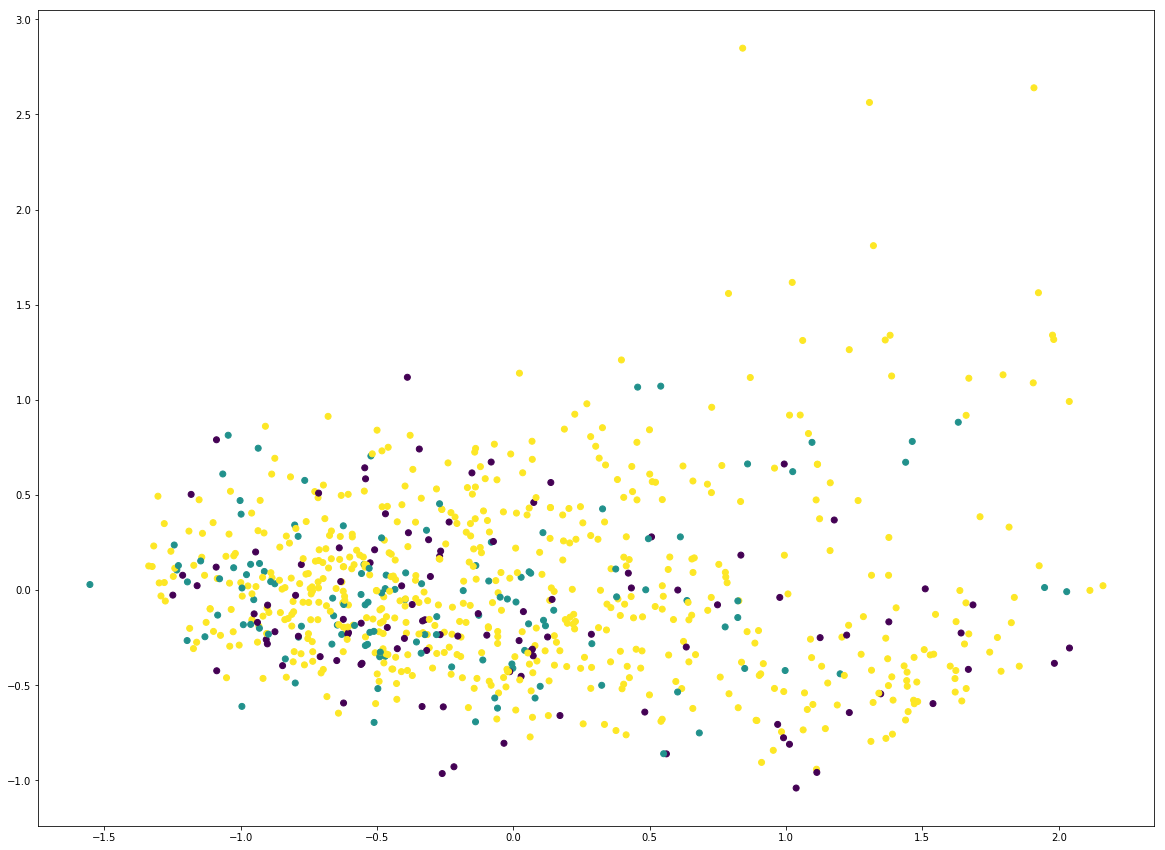

In [107]:
plt.figure(figsize=(20,15))
plt.scatter(feat_3d_numpy[:,0],feat_3d_numpy[:,1],c=train.loc[:806,'sentiment'])
plt.show()

In [0]:
from flair.models import text_classification_model

In [0]:
text_classification_model??

In [1]:
train.text.apply(lambda x:len(x)).max()

NameError: ignored